# Build an autonomous multi-agents workflow to write picture book
## Part 4

- Workflow_4 - Agentic Translation
- This workflow refers to the agentic translation process from Andrew Ng's work [translation-agent](https://github.com/andrewyng/translation-agent)
- In this step, we will create an agent called "linguist."
- The linguist agent performs the following tasks:
- It translates a text from the source language to the target language.
- It then reflects on the translation to come up with constructive suggestions for improving it.
- It uses these suggestions to improve the translation.
- There will be two files generated in this step, one is "story_transalated.json", the other is doc file ends with ".docx". The the doc file is your final artifact. You can download it to the local computer and read it.
- 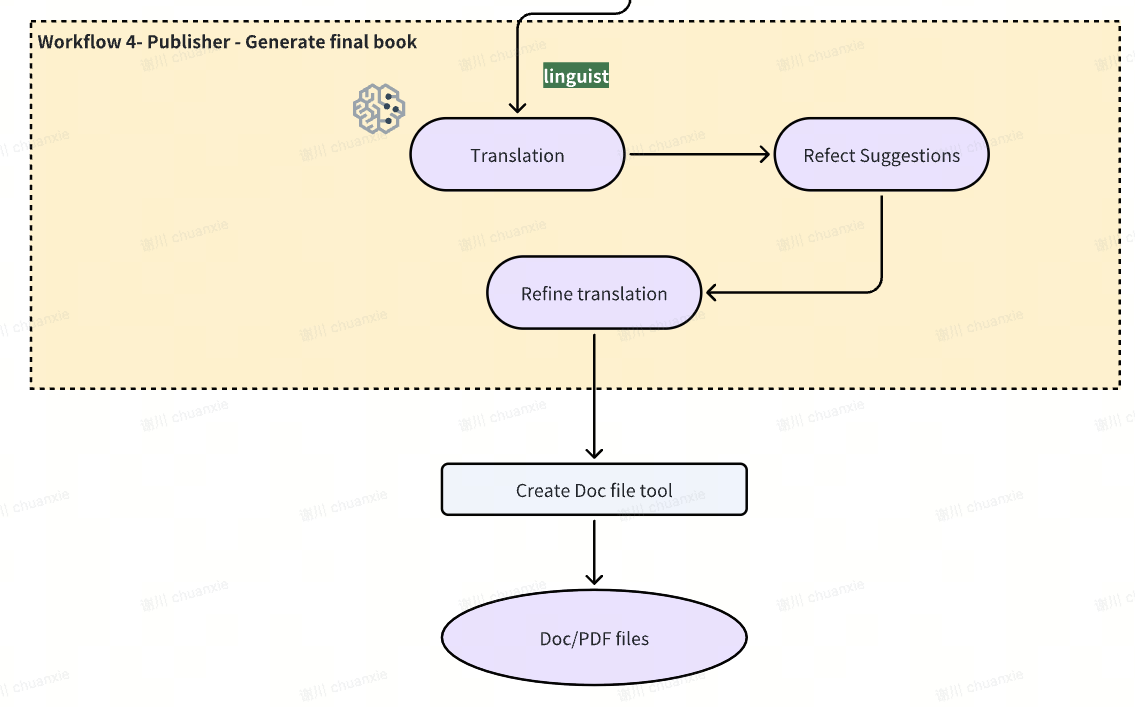

## 1. Install dependecies(if you already done in previous steps, you can skip it)

In [ ]:
%pip install -Uq langchain_community==0.2.12 langgraph==0.2.14 langchain-aws==0.1.17 langchain_core==0.2.35  python-docx==1.1.2 docx2pdf 

In [ ]:
%pip install -Uq boto3

## 2. Some Utils functions

### 2.1 Import Utils functions
- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [ ]:
from story_agents.llm_utils import CustJsonOuputParser,TextOuputParser,dict_to_obj

- we need to reconstruct the messages send to LLM strictly follow the turns ["user","assistant"]

In [ ]:
from story_agents.llm_utils import convert_message_name,reconstruct_to_claude_messages,swap_roles

### 2.2 Initiailize LLM models

In [ ]:
from langchain_aws import ChatBedrock
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# model_id = "mistral.mistral-large-2407-v1:0"
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
llm_sonnet = ChatBedrock(model_id=model_id,
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=False,
                )
llm = llm_sonnet

## 3 Agent Roles settings

- In this step, we will create an agent "linguist". 

In [ ]:
role_config = {
    "linguist":"You are an expert linguist specializing in translation from {source_lang} to {target_lang}."
}

## 4.Create Prompt templates and Chains

### 4.2 prompt templates
- Translation

In [ ]:
from story_agents.prompts import fc_desc
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

translation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['linguist']+fc_desc,
        ),
        (
            "user",
            """
            This is an {source_lang} to {target_lang} translation task, please provide the  {target_lang} translation for this text. 
            Do not provide any explanations or text apart from the translation.
            if the content has quotation mark, please change to single quotation mark instead
            {source_lang}: {source_text}

            Output transalated chatper:
            """
        ),  
    ]
)


review_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['linguist'],
        ),
        (
            "user",
            """
            You will be provided with a source text and its translation and your goal is to improve the translation.
            Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. 
            The final style and tone of the translation should match the style of {source_lang} colloquially spoken in {country}.

            The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:
            <SOURCE_TEXT>
            {source_text}
            </SOURCE_TEXT>
            <TRANSLATION>
            {translation_text}
            </TRANSLATION>
            When writing suggestions, pay attention to whether there are ways to improve the translation's 
            (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
            (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),
            (iii) style (by ensuring the translations reflect the style of the source text and takes into account any cultural context),
            (iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).
            Write a list of specific, helpful and constructive suggestions for improving the translation.
            Each suggestion should address one specific part of the translation.
            Output only the suggestions and nothing else.
            """
        ),  
    ]
)

refine_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['linguist']+fc_desc,
        ),
        (
            "user",
            """
           Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into account a list of expert suggestions and constructive criticisms.
            The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
            as follows:
            <SOURCE_TEXT>
            {source_text}
            </SOURCE_TEXT>
            <TRANSLATION>
            {translation_text}
            </TRANSLATION>
            <EXPERT_SUGGESTIONS>
            {expert_suggestions}
            </EXPERT_SUGGESTIONS>
            Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:
            (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
            (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
            (iii) style (by ensuring the translations reflect the style of the source text)
            (iv) terminology (inappropriate for context, inconsistent use), or
            (v) other errors.
            (vi) don't change \' to ".
            if the content has quotation mark, please change to single quotation mark instead
            Output transalated chatper:
            """
        ),  
    ]
)

In [ ]:
# translation_chain = translation_prompt|llm|CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
# translation_chain = translation_prompt|llm.with_structured_output(DetailChapter)

In [ ]:
# import json
# with open('story.json','r') as f:
#     story_json = json.load(f)
# story = Story.parse_obj(story_json)

# target_lang = "Chinese"
# response = translation_chain.invoke({"source_lang":"English", "target_lang":target_lang,
#     "source_text":story.chapters[0].json()})

In [ ]:
# response.json(ensure_ascii=False)

## 5 Build workflow graph

### 5.1 define node functions

In [ ]:
from story_agents.graph_utils import AgentState, retry_call,get_final_state_env_var
from langgraph.graph import StateGraph, END

In [ ]:
async def translate_chapter(state: AgentState):
    """
    translate single chapter

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    env_var = state['env_var']
    output_obj = env_var['output_obj']
    target_lang = env_var['target_lang']
    source_text = env_var['source_text']
    chain = translation_prompt|llm|CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=output_obj)
    chapter_obj = await retry_call(chain,
                               {"source_lang":"English", 
                                "target_lang":target_lang,
                                "schema":output_obj.schema_json(),
                                "source_text":source_text} )
    # chain = translation_prompt|llm.with_structured_output(DetailChapter)
    # chapter_obj = await chain.ainvoke( {"source_lang":"English", 
    #                                 "target_lang":target_lang,
    #                                 "source_text":source_text} )
    return {"env_var":{**env_var,"translation_text":chapter_obj.json(ensure_ascii=False)}}


In [ ]:
async def reflect_review(state: AgentState):
    """
    reflect and provide suggestion on translated content

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    env_var = state['env_var']
    target_lang = env_var['target_lang']
    source_text = env_var['source_text']
    country = env_var['country']
    translation_text = env_var['translation_text']
    chain = review_prompt|llm|StrOutputParser()
    expert_suggestions = await chain.ainvoke({"source_lang":"English", 
                                    "target_lang":target_lang,
                                    "translation_text":translation_text,
                                    "country":country,
                                    "source_text":source_text})
                                
    return {"env_var":{**env_var,"expert_suggestions":expert_suggestions}}

In [ ]:
async def refine(state: AgentState):
    """
    translate single chapter

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    env_var = state['env_var']
    target_lang = env_var['target_lang']
    source_text = env_var['source_text']
    output_obj = env_var['output_obj']
    expert_suggestions = env_var['expert_suggestions']
    translation_text = env_var['translation_text']
    # chain = refine_prompt|llm.with_structured_output(DetailChapter)
    # chapter_obj = await chain.ainvoke({"source_lang":"English", 
    #                             "target_lang":target_lang,
    #                             "translation_text":translation_text,
    #                             "expert_suggestions":expert_suggestions,
    #                             "source_text":source_text})
    chain = refine_prompt|llm|CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=output_obj)
    chapter_obj = await retry_call(chain,
                                   {"source_lang":"English", 
                                    "target_lang":target_lang,
                                    "schema":output_obj.schema_json(),
                                    "translation_text":translation_text,
                                    "expert_suggestions":expert_suggestions,
                                    "source_text":source_text} )
    return {"env_var":{**env_var,"final_translation":chapter_obj}}

### 5.2 Define edges

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("translate_chapter",translate_chapter)
graph.add_node("reflect_review",reflect_review)
graph.add_node("refine",refine)
graph.set_entry_point("translate_chapter")

graph.add_edge("translate_chapter","reflect_review")
graph.add_edge("reflect_review","refine")
graph.add_edge("refine",END)
workflow = graph.compile()

- visualize the flow

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

### Let's translate one chapter for test Run
### Change the country and target_lang as you wish

#### let's test run - translate a single chapter
- Here you need to load the json files created from last notebook

In [ ]:
import json
from story_agents.structure_objects import Story,DetailChapter,Character
with open('story.json','r') as f:
    story_json = json.load(f)
story = Story.parse_obj(story_json)

with open('characters.json','r') as f:
    characters_json = json.load(f)
characters = Character.parse_obj(characters_json)

### Change the country and target_lang as you wish

In [ ]:
country = 'China'
target_lang = 'Mandarin'

In [ ]:
story.chapters[2].json()

In [ ]:

steps = []
init_state = {
    "env_var":{"target_lang":target_lang,
               "country":country,
               "output_obj":DetailChapter,
               "source_text":story.chapters[2].json()},
}
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

In [ ]:
print(get_final_state_env_var(steps,'refine')['final_translation'])

### 5.4 let's use batch function to write each chapter

In [ ]:
async def translate_all_chapters(chapter,target_lang,country):
    init_state = {
        "env_var":{"target_lang":target_lang,
                   "country":country,
                   "source_text":chapter.json()},
    }     
    steps = []
    async for event in workflow.astream(input=init_state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    ret = get_final_state_env_var(steps,'refine')['final_translation']
    return ret

In [ ]:
chaps = [ chatper for chatper in  story.chapters]

In [ ]:
write_all = RunnableLambda(translate_all_chapters).bind(target_lang=target_lang,country=country)
all_steps =  await write_all.abatch(chaps)

In [ ]:
chapters_translated=[s for s in all_steps]
chapters_translated

### 5.5 Translate Story Title and Character description

#### translate title

In [ ]:
from story_agents.structure_objects import Title

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Title(BaseModel):
    title: str = Field(..., description="Title of the story book")

In [ ]:
steps = []
init_state = {
    "env_var":{"target_lang":target_lang,
               "country":country,
               "output_obj":Title,
               "source_text":story.story_title},
}
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

In [ ]:
title_translated = get_final_state_env_var(steps,'refine')['final_translation']
print(title_translated)

#### Translate characters

In [ ]:
steps = []
init_state = {
    "env_var":{"target_lang":target_lang,
               "country":country,
               "output_obj":Character,
               "source_text":characters.json()},
}
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


In [ ]:
characters_translated = get_final_state_env_var(steps,'refine')['final_translation']
print(characters_translated)

### 5.6 merge all Chapters and Characters together

In [ ]:
story_translated = story.copy()
story_translated.chapters = chapters_translated
story_translated.story_title = title_translated.title

In [ ]:
print(story_translated)

- save to json file

In [ ]:
with open('story_transalated.json','w') as f:
    f.write(story_translated.json())

## 6. Save to docx file

In [ ]:
from story_agents.image_utils import save_as_docx

In [ ]:
save_as_docx(characters_translated,story_translated,f'{story.story_title}_{target_lang}.docx')